In [ ]:
# Ch 0.2.0: PareUNet2DConditionModel

## Part 0: Setup

In [1]:
# Install diffusers
!pip install transformers diffusers accelerate -U
!pip install parediffusers==0.1.2

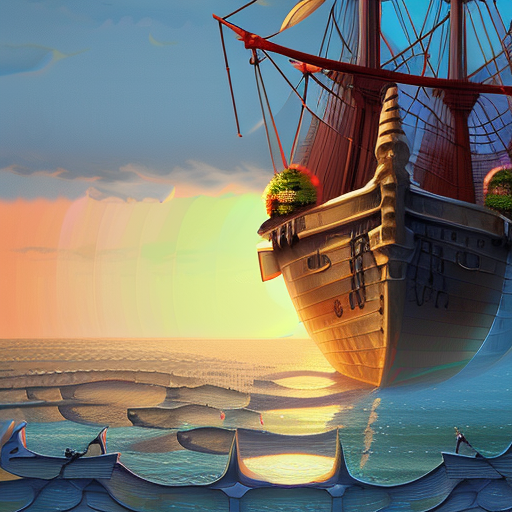

In [3]:
import torch
from PIL import Image
from torchvision.transforms import ToPILImage
from transformers import CLIPTokenizer, CLIPTextModel
from parediffusers import PareDDIMScheduler

from diffusers import UNet2DConditionModel, AutoencoderKL

class PareDiffusionPipeline:
	def __init__(self, tokenizer, text_encoder, scheduler, unet, vae, device=torch.device("cuda"), dtype=torch.float16):
		"""
		Initialize the diffusion pipeline components.
		"""
		self.tokenizer = tokenizer
		self.text_encoder = text_encoder.to(device=device, dtype=dtype)
		self.scheduler = scheduler
		self.unet = unet.to(device=device, dtype=dtype)
		self.vae = vae.to(device=device, dtype=dtype)
		self.device = device
		self.dtype = dtype

	@classmethod
	def from_pretrained(cls, model_name, device=torch.device("cuda"), dtype=torch.float16):
		"""
		Load all necessary components from the pretrained model.

		Args:
			model_name (str): The name of the pretrained model.
			device (torch.device, optional): The device to use for the pipeline. Defaults to torch.device("cuda").
			dtype (torch.dtype, optional): The dtype to use for the pipeline. Defaults to torch.float16.
		
		Returns:
			PareDiffusionPipeline: The initialized pipeline.
		"""
		tokenizer = CLIPTokenizer.from_pretrained(model_name, subfolder="tokenizer")
		text_encoder = CLIPTextModel.from_pretrained(model_name, subfolder="text_encoder")
		scheduler = PareDDIMScheduler.from_config(model_name, subfolder="scheduler")
		unet = UNet2DConditionModel.from_pretrained(model_name, subfolder="unet")
		vae = AutoencoderKL.from_pretrained(model_name, subfolder="vae")
		return cls(tokenizer, text_encoder, scheduler, unet, vae, device, dtype)

	def encode_prompt(self, prompt: str):
		"""
		Encode the text prompt into embeddings using the text encoder.
		"""
		prompt_embeds = self.get_embes(prompt, self.tokenizer.model_max_length)
		negative_prompt_embeds = self.get_embes([''], prompt_embeds.shape[1])
		prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds])
		return prompt_embeds

	def get_embes(self, prompt, max_length):
		"""
		Encode the text prompt into embeddings using the text encoder.
		"""
		text_inputs = self.tokenizer(prompt, padding="max_length", max_length=max_length, truncation=True, return_tensors="pt")
		text_input_ids = text_inputs.input_ids.to(self.device)
		prompt_embeds = self.text_encoder(text_input_ids)[0].to(dtype=self.dtype, device=self.device)
		return prompt_embeds

	def get_latent(self, width: int, height: int):
		"""
		Generate a random initial latent tensor to start the diffusion process.
		"""
		return torch.randn((4, width // 8, height // 8)).to(
			device=self.device, dtype=self.dtype
		)

	def retrieve_timesteps(self, num_inference_steps=None):
		"""
		Retrieve the timesteps for the diffusion process from the scheduler.
		"""
		self.scheduler.set_timesteps(num_inference_steps, device=self.device)
		timesteps = self.scheduler.timesteps
		return timesteps, num_inference_steps

	@torch.no_grad()
	def denoise(self, latents, prompt_embeds, num_inference_steps=50, guidance_scale=7.5):
		"""
		Iteratively denoise the latent space using the diffusion model to produce an image.
		"""
		timesteps, num_inference_steps = self.retrieve_timesteps(num_inference_steps)
	
		for t in timesteps:
			latent_model_input = torch.cat([latents] * 2)
			
			# Predict the noise residual for the current timestep
			noise_residual = self.unet(latent_model_input, t, encoder_hidden_states=prompt_embeds)[0]
			uncond_residual, text_cond_residual = noise_residual.chunk(2)
			guided_noise_residual = uncond_residual + guidance_scale * (text_cond_residual - uncond_residual)

			# Update latents by reversing the diffusion process for the current timestep
			latents = self.scheduler.step(guided_noise_residual, t, latents)[0]

		return latents
	
	def denormalize(self, image):
		"""
		Denormalize the image tensor to the range [0, 255].
		"""
		return (image / 2 + 0.5).clamp(0, 1)

	def tensor_to_image(self, tensor):
		"""
		Convert a tensor to a PIL Image.
		"""
		return ToPILImage()(tensor.detach().cpu())

	@torch.no_grad()
	def vae_decode(self, latents):
		"""
		Decode the latent tensors using the VAE to produce an image.
		"""
		image = self.vae.decode(latents / self.vae.config.scaling_factor)[0][0]
		image = self.denormalize(image)
		image = self.tensor_to_image(image)
		return image

	def __call__(self, prompt: str, height: int = 512, width: int = 512, num_inference_steps: int = 50, guidance_scale: int = 7.5):
		"""
		Generate an image from a text prompt using the entire pipeline.

		Args:
			prompt (str): The text prompt to generate an image from.
			height (int, optional): The height of the generated image. Defaults to 512.
			width (int, optional): The width of the generated image. Defaults to 512.
			num_inference_steps (int, optional): The number of diffusion steps to perform. Defaults to 50.
			guidance_scale (int, optional): The scale of the guidance. Defaults to 7.5.
		
		Returns:
			PIL.Image: The generated image.
		"""
		prompt_embeds = self.encode_prompt(prompt)
		latents = self.get_latent(width, height).unsqueeze(dim=0)
		latents = self.denoise(latents, prompt_embeds, num_inference_steps, guidance_scale)
		image = self.vae_decode(latents)
		return image
	

device = torch.device("cuda")
dtype = torch.float16
model_name = "stabilityai/stable-diffusion-2"
width = 512
height = 512
num_inference_steps = 50

pipe = PareDiffusionPipeline.from_pretrained(model_name)

prompt = "painting depicting the sea, sunrise, ship, artstation, 4k, concept art"
image = pipe(prompt)
image.show()

## Part 2: Get values of UNet

In [3]:
unet = UNet2DConditionModel.from_pretrained(model_name, subfolder="unet").to(
	device=device, dtype=dtype
)
unet

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): LoRACompatibleLinear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): LoRACompatibleLinear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0): Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): LoRACompatibleLinear(in_features=320, out_features=320, bias=True)
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): LoRACompatibleLinear(in_features=320, out_features=320, bias=False)
                (to_k): LoRACompatibleLinear(in_features=320, out_features=320, b

## Part 3: Check How Works from_pretrained

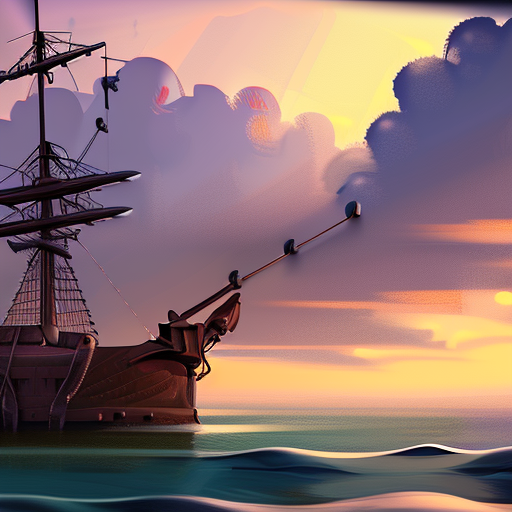

In [4]:
from diffusers.utils import (
	_get_model_file,
	_add_variant,
	WEIGHTS_NAME,
)

def from_pretrained(model_name, **kwargs):
	subfolder = kwargs.pop("subfolder", None)

	user_agent = {
		"diffusers": -1,
		"file_type": "model",
		"framework": "pytorch",
	}

	# load config
	config, unused_kwargs, commit_hash = UNet2DConditionModel.load_config(
		model_name,
		cache_dir=None,
		return_unused_kwargs=True,
		return_commit_hash=True,
		force_download=None,
		resume_download=None,
		proxies=None,
		local_files_only=None,
		token=None,
		revision=None,
		subfolder=subfolder,
		device_map=None,
		max_memory=None,
		offload_folder=None,
		offload_state_dict=None,
		user_agent=user_agent,
		**kwargs,
	)


	model_file = _get_model_file(
		model_name,
		weights_name=_add_variant(WEIGHTS_NAME, None),
		cache_dir=None,
		force_download=None,
		resume_download=None,
		proxies=None,
		local_files_only=None,
		token=None,
		revision=None,
		subfolder=subfolder,
		user_agent=user_agent,
		commit_hash=commit_hash,
	)

	model = UNet2DConditionModel.from_config(config, **unused_kwargs)
	state_dict = torch.load(model_file, map_location="cpu")
	model._convert_deprecated_attention_blocks(state_dict)

	model, _, _, _, _ = UNet2DConditionModel._load_pretrained_model(
		model,
		state_dict,
		model_file,
		model_name,
		ignore_mismatched_sizes=None,
	)
	model.register_to_config(_name_or_path=model_name)
	model.eval()
	return model

pare_unet = from_pretrained("stabilityai/stable-diffusion-2", subfolder="unet").to(
	device=device, dtype=dtype
)
pipe.unet = pare_unet

image = pipe(prompt)
image.show()


### Part 3.1: get_config

In [23]:
import json
from huggingface_hub import hf_hub_download

def get_config(model_name, subfolder=None):
	config_file = hf_hub_download(
		model_name,
		filename="config.json",
		subfolder=subfolder,
	)
	with open(config_file, "r", encoding="utf-8") as reader:
		text = reader.read()
	config = json.loads(text)
	return config

config = get_config(model_name, subfolder="unet")
config

{'_class_name': 'UNet2DConditionModel',
 '_diffusers_version': '0.8.0',
 '_name_or_path': 'hf-models/stable-diffusion-v2-768x768/unet',
 'act_fn': 'silu',
 'attention_head_dim': [5, 10, 20, 20],
 'block_out_channels': [320, 640, 1280, 1280],
 'center_input_sample': False,
 'cross_attention_dim': 1024,
 'down_block_types': ['CrossAttnDownBlock2D',
  'CrossAttnDownBlock2D',
  'CrossAttnDownBlock2D',
  'DownBlock2D'],
 'downsample_padding': 1,
 'dual_cross_attention': False,
 'flip_sin_to_cos': True,
 'freq_shift': 0,
 'in_channels': 4,
 'layers_per_block': 2,
 'mid_block_scale_factor': 1,
 'norm_eps': 1e-05,
 'norm_num_groups': 32,
 'out_channels': 4,
 'sample_size': 96,
 'up_block_types': ['UpBlock2D',
  'CrossAttnUpBlock2D',
  'CrossAttnUpBlock2D',
  'CrossAttnUpBlock2D'],
 'use_linear_projection': True}

### Part 3.2: Download model

In [24]:
model_file = hf_hub_download(
	model_name,
	filename="diffusion_pytorch_model.fp16.bin",
	subfolder="unet",
)
state_dict = torch.load(model_file, map_location="cpu")
state_dict

OrderedDict([('conv_in.weight',
              tensor([[[[-2.8732e-02,  1.9669e-02,  7.6233e-02],
                        [-1.8372e-02, -1.3074e-01,  1.0529e-01],
                        [-1.0185e-02, -1.6724e-02,  3.2440e-02]],
              
                       [[ 4.2786e-02, -6.3538e-02,  4.5586e-03],
                        [ 1.2634e-01, -1.0089e-01, -3.9551e-02],
                        [ 9.1324e-03, -8.7433e-03,  1.0521e-02]],
              
                       [[ 1.7776e-02, -1.6830e-02,  3.2532e-02],
                        [-2.0859e-02,  2.3590e-02,  3.9490e-02],
                        [-5.3329e-03, -5.8479e-03, -1.5900e-02]],
              
                       [[ 2.5375e-02, -3.3691e-02,  2.0416e-02],
                        [ 2.0905e-02, -7.9712e-02,  6.3843e-02],
                        [ 1.2159e-03, -2.4597e-02,  1.9287e-02]]],
              
              
                      [[[ 9.8877e-03, -7.3395e-03, -3.1174e-02],
                        [ 9.8953e-03,  2.05

In [47]:
model = UNet2DConditionModel.from_config(config)
model._convert_deprecated_attention_blocks(state_dict)
def load(module: torch.nn.Module, prefix: str = ""):
	args = (state_dict, prefix, {}, True, [], [], error_msgs)
	module._load_from_state_dict(*args)
	for name, child in module._modules.items():
		if child is not None:
			load(child, prefix + name + ".")

load(model)

model

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): LoRACompatibleLinear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): LoRACompatibleLinear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0): Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): LoRACompatibleLinear(in_features=320, out_features=320, bias=True)
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): LoRACompatibleLinear(in_features=320, out_features=320, bias=False)
                (to_k): LoRACompatibleLinear(in_features=320, out_features=320, b

### Part 3.3: class PareUNet2DConditionModel

In [45]:
import json
from typing import List
import torch
from huggingface_hub import hf_hub_download
from diffusers import UNet2DConditionModel

class PareUNet2DConditionModel(torch.nn.Module):
	def __init__(self, unet):
		super().__init__()
		self.unet = unet
	
	@classmethod
	def _get_config(cls, model_name, filename="config.json", subfolder=None):
		config_file = hf_hub_download(
			model_name,
			filename=filename,
			subfolder=subfolder,
		)
		with open(config_file, "r", encoding="utf-8") as reader:
			text = reader.read()
		config = json.loads(text)
		return config

	@classmethod
	def _load_state_dict_into_model(cls, model, state_dict) -> List[str]:
		state_dict = state_dict.copy()
		error_msgs = []

		def load(module: torch.nn.Module, prefix: str = ""):
			args = (state_dict, prefix, {}, True, [], [], error_msgs)
			module._load_from_state_dict(*args)
			for name, child in module._modules.items():
				if child is not None:
					load(child, prefix + name + ".")
		
		load(model)
		return model
	
	@classmethod
	def from_pretrained(cls, model_name, **kwargs):
		subfolder = kwargs.pop("subfolder", "unet")
		config_filename = kwargs.pop("config_filename", "config.json")
		model_filename = kwargs.pop("model_filename", "diffusion_pytorch_model.fp16.bin")
		
		config = cls._get_config(model_name, filename=config_filename, subfolder=subfolder)
		model_file = hf_hub_download(
			model_name,
			filename=model_filename,
			subfolder=subfolder,
		)
		state_dict = torch.load(model_file, map_location="cpu")
		
		model = UNet2DConditionModel.from_config(config)
		model._convert_deprecated_attention_blocks(state_dict)
		model = cls._load_state_dict_into_model(model, state_dict)
		model.register_to_config(_name_or_path=model_name)
		model.eval()
		return model


pare_unet = PareUNet2DConditionModel.from_pretrained("stabilityai/stable-diffusion-2",).to(
	device=device,
	dtype=dtype
)

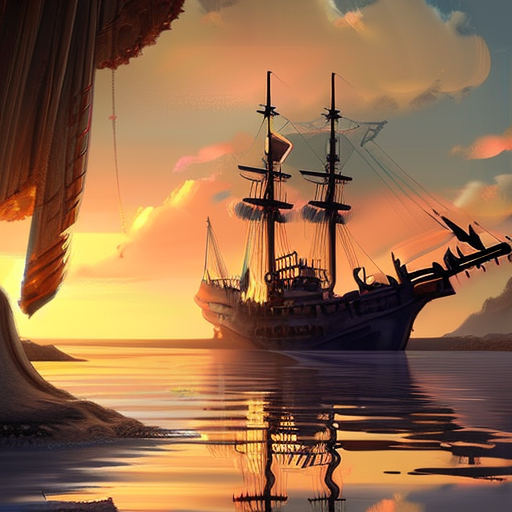

In [46]:
pipe.unet = pare_unet

image = pipe(prompt)
image.show()